1. Data Preparation
- Load OHLCV data for all selected tickers (e.g., AMZN, META, AVGO, ETFs)
- Normalize features per ticker (z-score or min-max scaling)
- Add metadata: ticker_id, sector, day_of_week, macro regime (optional)
- Create rolling windows for time series modeling (e.g., 10-day sequences)
2. Feature Engineering
- Technical indicators: RSI, MACD, Bollinger Bands, ATR
- Candle features: range, body size, wick ratios
- Volume features: OBV, VWAP, volume spikes
- Lagged returns, volatility, momentum scores
3. Labeling Strategy
- Define swing trade targets:
- Binary: Will price rise >x% in next n days?
- Multi-class: Uptrend / Downtrend / Sideways
- Regression: Expected return over next n days

#### Dependencies

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import spearmanr, pearsonr
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
# from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator, StochRSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator

In [4]:
print(torch.__version__)
print(torch.version.cuda) 
print(torch.cuda.is_available())   # True if a GPU is detected
print(torch.cuda.device_count())   # Number of GPUs available
# print(torch.cuda.get_device_name(0))  # Name of the first GPU

2.9.0+cu128
12.8
True
1


#### Datacollation

In [5]:
tickers = ["AMZN", "META", "AVGO", "LLY", "ETN", "CYBR", "LIN", "WM", "SLNO", "CYTK", "XLV"]
exclude = ["SPY", "TLT", "LQD", "VNQ"]
leadup_days = 0
start_date = (datetime.strptime("2015-01-01", "%Y-%m-%d") - timedelta(days=leadup_days)).strftime("%Y-%m-%d")
raw_data = yf.download(tickers, interval="1d", start=start_date, end="2025-01-01", group_by="ticker")

C:\Users\DLinger\AppData\Local\Temp\ipykernel_14064\1402805924.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, interval="1d", start=start_date, end="2025-01-01", group_by="ticker")
[*********************100%***********************]  11 of 11 completed


In [6]:
print(raw_data.info())
display(raw_data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-02 to 2024-12-31
Data columns (total 55 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (META, Open)    2516 non-null   float64
 1   (META, High)    2516 non-null   float64
 2   (META, Low)     2516 non-null   float64
 3   (META, Close)   2516 non-null   float64
 4   (META, Volume)  2516 non-null   int64  
 5   (AMZN, Open)    2516 non-null   float64
 6   (AMZN, High)    2516 non-null   float64
 7   (AMZN, Low)     2516 non-null   float64
 8   (AMZN, Close)   2516 non-null   float64
 9   (AMZN, Volume)  2516 non-null   int64  
 10  (SLNO, Open)    2516 non-null   float64
 11  (SLNO, High)    2516 non-null   float64
 12  (SLNO, Low)     2516 non-null   float64
 13  (SLNO, Close)   2516 non-null   float64
 14  (SLNO, Volume)  2516 non-null   int64  
 15  (WM, Open)      2516 non-null   float64
 16  (WM, High)      2516 non-null   float64
 17  (WM, Low)      

Ticker         META                                                       \
Price          Open         High          Low        Close        Volume   
count   2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03   
mean     220.885829   223.693936   218.142241   220.982814  2.288157e+07   
std      121.236244   122.688194   119.678310   121.199533  1.489255e+07   
min       73.586368    74.371519    71.558867    73.596306  4.726100e+06   
25%      135.184122   136.958220   133.405083   135.566780  1.440050e+07   
50%      181.938404   184.065297   180.055017   181.968216  1.921050e+07   
75%      277.457069   283.484924   274.594708   279.151619  2.639298e+07   
max      629.520541   636.398941   625.244010   630.696838  2.323166e+08   

Ticker         AMZN                                                       ...  \
Price          Open         High          Low        Close        Volume  ...   
count   2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03  ...   
mean     101.257296   102.406018   100.004404   101.233089  7.614499e+07  ...   
std       54.200851    54.819315    53.526627    54.173887  4.061966e+07  ...   
min       14.314000    14.539500    14.262500    14.347500  1.500750e+07  ...   
25%       48.583500    48.828251    48.087127    48.397126  5.071022e+07  ...   
50%       94.557999    95.556000    93.452499    94.572502  6.526200e+07  ...   
75%      153.875378   155.906128   151.730000   153.856247  9.008800e+07  ...   
max      232.389999   233.000000   228.009995   232.929993  4.771220e+08  ...   

Ticker          LIN                                                       \
Price          Open         High          Low        Close        Volume   
count   2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03   
mean     219.203304   220.972602   217.504433   219.303473  1.777472e+06   
std      113.688031   114.464103   112.941091   113.746493  1.846975e+06   
min       81.259904    82.632200    80.485371    80.931564  2.764000e+05   
25%      115.741972   116.391867   114.896121   115.650085  1.163075e+06   
50%      184.186156   185.143147   183.148556   184.102470  1.510500e+06   
75%      301.735688   304.612688   299.012770   301.660255  1.975575e+06   
max      480.762073   481.324841   478.254187   480.298035  5.737560e+07   

Ticker         CYTK                                                       
Price          Open         High          Low        Close        Volume  
count   2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03  
mean      23.370505    23.973092    22.776761    23.382786  8.947817e+05  
std       18.093643    18.540738    17.639903    18.111173  1.523910e+06  
min        5.510000     5.710000     5.500000     5.510000  4.280000e+04  
25%        8.847500     9.000000     8.565000     8.815000  3.339750e+05  
50%       14.300000    14.590000    13.990000    14.250000  6.006000e+05  
75%       35.982500    36.947499    35.020000    35.950001  1.004900e+06  
max      108.550003   110.250000    97.629997   108.059998  4.013750e+07  

[8 rows x 55 columns]

#### Initialize important functions

In [7]:
def add_indicators(df):
    df = df.copy()
    
    # General price dynamics
    df["returns"] = df["Close"].pct_change()
    df["logReturns"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Volatility"] = df["returns"].rolling(10).std()
    df['Range'] = df['High'] - df['Low']
    df['Body'] = abs(df['Close'] - df['Open'])
    df['Wick'] = df['Range'] - df['Body']

    # Momentum
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    df['StochRSI'] = StochRSIIndicator(df['Close'], window=14).stochrsi()
    
    # Short-term moving averages (faster response)
    df['SMA_10'] = SMAIndicator(df['Close'], window=10).sma_indicator()
    df['EMA_10'] = EMAIndicator(df['Close'], window=10).ema_indicator()

    # Medium-term moving averages (faster than previous 50)
    df['SMA_20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_20'] = EMAIndicator(df['Close'], window=20).ema_indicator()

    # Optional: slightly faster “long-term” averages for crossovers
    df['SMA_30'] = SMAIndicator(df['Close'], window=30).sma_indicator()
    df['EMA_30'] = EMAIndicator(df['Close'], window=30).ema_indicator()

    # Faster MACD for earlier crossovers
    macd = MACD(df['Close'], window_slow=13, window_fast=6, window_sign=5)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    
    df['MACD_rel'] = df['MACD'] / df['Close']
    df['MACD_Signal_rel'] = df['MACD_Signal'] / df['Close']
    
    # Volatility
    bb = BollingerBands(df['Close'], window=20)
    df['BB_High'] = bb.bollinger_hband()
    df['BB_Low'] = bb.bollinger_lband()
    df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
    
    # Volume
    df['OBV'] = OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    df['OBV_prev'] = pd.to_numeric(df['OBV'].shift(1), errors='coerce').fillna(0).astype(int)
    df['CMF'] = ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume'], window=20).chaikin_money_flow()
    
    return df

In [ ]:
""" | Indicator(s)             | Rule                                                                            | Label |
    | ------------------------ | ------------------------------------------------------------------------------- | ----- |
    | MACD & MACD_Signal       | If `MACD > MACD_Signal` → **Buy**, if `MACD < MACD_Signal` → **Sell**           | ±1    |
    | RSI                      | If `RSI < 30` → **Buy** (oversold), if `RSI > 70` → **Sell** (overbought)       | ±1    |
    | StochRSI                 | If `StochRSI < 0.2` → **Buy**, if `StochRSI > 0.8` → **Sell**                   | ±1    |
    | SMA / EMA                | If `Close > SMA_20` → **Buy**, if `Close < SMA_20` → **Sell**                   | ±1    |
    | Bollinger Bands          | If `Close < BB_Low` → **Buy**, if `Close > BB_High` → **Sell**                  | ±1    |
    | OBV (On-Balance Volume)  | If `OBV > OBV_prev` → **Buy**, if `OBV < OBV_prev` → **Sell**                   | ±1    |
    | CMF (Chaikin Money Flow) | If `CMF > 0` → **Buy**, if `CMF < 0` → **Sell**                                 | ±1    |
    | Volatility / ATR         | If `Volatility` or `ATR` is high, reduce conviction (set to `0` to avoid noise) | 0     |
"""

def signal_engine(df):
    df = df.copy()

    # Initialize vote counter
    votes = np.zeros(len(df), dtype=float)

    # ---- Weighted voting system ----
    # Stronger weights = more historically reliable / consistent indicator
    w = {
        # Core momentum/trend indicators
        'MACD': 1.0,
        'RSI': 0.8,
        'StochRSI': 0.6,

        # Short / medium / long-term trend indicators
        'SMA_10': 0.9,           # Short-term trend
        'SMA_20': 1.0,           # Medium-term trend
        'SMA_30': 1.1,           # Long-term anchor
        'SMA_cross': 1.0,        # 10 vs 20 crossover
        'SMA_long_cross': 1.0,   # 20 vs 30 crossover

        'EMA_10': 0.9,
        'EMA_20': 1.0,
        'EMA_30': 1.1,
        'EMA_cross': 1.0,
        'EMA_long_cross': 1.0,

        # Volatility and confirmation indicators
        'BB': 0.75,
        'OBV': 0.9,
        'CMF': 0.8,
        'Body': 0.6,
        'Wick': 0.8,
        'Volatility': 0.4,
    }

    # --- Apply rules ---
     # Shift indicators by 1 bar to avoid lookahead
    df_shift = df.shift(1)

    # --- Apply rules with shifted indicators ---
    
    # MACD crossover
    votes += w['MACD'] * np.where(df_shift['MACD'] > df_shift['MACD_Signal'], 1, 
                                  np.where(df_shift['MACD'] < df_shift['MACD_Signal'], -1, 0))
    
    # RSI thresholds
    votes += w['RSI'] * np.where(df_shift['RSI'] < 30, 1, 
                                 np.where(df_shift['RSI'] > 70, -1, 0))
    
    # StochRSI thresholds
    votes += w['StochRSI'] * np.where(df_shift['StochRSI'] < 0.2, 1, 
                                      np.where(df_shift['StochRSI'] > 0.8, -1, 0))
    
    # RSI divergence (optional)
    rsi_div = (df_shift['RSI'] > df_shift['RSI'].shift(1)) & (df_shift['Close'] < df_shift['Close'].shift(1))
    votes += 0.6 * np.where(rsi_div, -1, 0)
    
    # --- Short-term and medium-term trend signals ---

    # # SMA trend signals
    # votes += w['SMA_10'] * np.where(df_shift['Close'] > df_shift['SMA_10'], 1,
    #                                 np.where(df_shift['Close'] < df_shift['SMA_10'], -1, 0))
    # votes += w['SMA_20'] * np.where(df_shift['Close'] > df_shift['SMA_20'], 1,
    #                                 np.where(df_shift['Close'] < df_shift['SMA_20'], -1, 0))

    # # SMA crossover (short vs medium)
    # votes += w['SMA_cross'] * np.where(df_shift['SMA_10'] > df_shift['SMA_20'], 1,
    #                                 np.where(df_shift['SMA_10'] < df_shift['SMA_20'], -1, 0))

    # EMA trend signals
    votes += w['EMA_10'] * np.where(df_shift['Close'] > df_shift['EMA_10'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_10'], -1, 0))
    votes += w['EMA_20'] * np.where(df_shift['Close'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_20'], -1, 0))

    # EMA crossover (short vs medium)
    votes += w['EMA_cross'] * np.where(df_shift['EMA_10'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['EMA_10'] < df_shift['EMA_20'], -1, 0))

    # Optional: long-term trend anchors
    votes += w['SMA_30'] * np.where(df_shift['Close'] > df_shift['SMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_30'] * np.where(df_shift['Close'] > df_shift['EMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_30'], -1, 0))
    
    # Long-term crossover (medium vs long)
    votes += w['SMA_long_cross'] * np.where(df_shift['SMA_20'] > df_shift['SMA_30'], 1,
                                            np.where(df_shift['SMA_20'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_long_cross'] * np.where(df_shift['EMA_20'] > df_shift['EMA_30'], 1,
                                            np.where(df_shift['EMA_20'] < df_shift['EMA_30'], -1, 0))
    
    # Bollinger Bonds breakout
    votes += w['BB'] * np.where(df_shift['Close'] < df_shift['BB_Low'], 1, 
                                np.where(df_shift['Close'] > df_shift['BB_High'], -1, 0))
    
    # OBV momentum
    votes += w['OBV'] * np.where(df_shift['OBV'] > df_shift['OBV_prev'], 1, 
                                 np.where(df_shift['OBV'] < df_shift['OBV_prev'], -1, 0))
    
    # CNF accumulation/distribution
    votes += w['CMF'] * np.where(df_shift['CMF'] > 0, 1, np.where(df_shift['CMF'] < 0, -1, 0))

    # Candle body momentum
    body_avg = df_shift['Body'].rolling(5, min_periods=1).mean()
    votes += w['Body'] * np.where(df_shift['Body'] > body_avg, 1, np.where(df_shift['Body'] < body_avg, -1, 0))

    # Wick exhaustion
    votes += w['Wick'] * np.where(df_shift['Wick'] > df_shift['Range'] * 0.6, -1, 
                                  np.where(df_shift['Wick'] < df_shift['Range'] * 0.1, 1, 0))
    
    # Bearish engulfing candle
    bear_engulf = (df_shift['Open'] < df_shift['Close']) & (df_shift['Close'] < df_shift['Open'].shift(1)) & (df_shift['Open'] > df_shift['Close'].shift(1))
    votes += 0.8 * np.where(bear_engulf, -1, 0)


    # Volatility contraction
    vol_avg = df_shift['Volatility'].rolling(10, min_periods=1).mean()
    votes += w['Volatility'] * np.where(df_shift['Volatility'] < vol_avg, 1, 0)

    # --- Targeted volatility soft gate ---
    atr_mean = df_shift['ATR'].rolling(50, min_periods=10).mean()
    atr_std = df_shift['ATR'].rolling(50, min_periods=10).std()
    high_atr = df_shift['ATR'] > (atr_mean + 2 * atr_std)

    scale = np.ones(len(df))
    scale[high_atr] = np.clip((atr_mean[high_atr] + 2 * atr_std[high_atr]) / df_shift['ATR'][high_atr], 0.3, 1.0)
    votes *= scale

    # --- Preliminary label ---
    prelim_label = np.where(votes > 4, 1, np.where(votes < -4, -1, 0))

    # --- Soft fallback logic for weak votes ---
    fallback_zone = (prelim_label == 0) & (np.abs(votes) <= 2)
    soft_vote_strength = 0.5
    low_vol = df_shift['ATR'] < atr_mean
    fallback_bear = (df_shift['EMA_10'] < df_shift['EMA_20']) & fallback_zone & low_vol
    fallback_bull = (df_shift['EMA_10'] > df_shift['EMA_20']) & fallback_zone & low_vol

    prelim_label[fallback_bull] = soft_vote_strength
    prelim_label[fallback_bear] = -soft_vote_strength

    # list the vote_totals
    df['vote_total'] = votes

    return df

In [9]:
""" | Indicator(s)             | Rule                                                                            | Label |
    | ------------------------ | ------------------------------------------------------------------------------- | ----- |
    | MACD & MACD_Signal       | If `MACD > MACD_Signal` → **Buy**, if `MACD < MACD_Signal` → **Sell**           | ±1    |
    | RSI                      | If `RSI < 30` → **Buy** (oversold), if `RSI > 70` → **Sell** (overbought)       | ±1    |
    | StochRSI                 | If `StochRSI < 0.2` → **Buy**, if `StochRSI > 0.8` → **Sell**                   | ±1    |
    | SMA / EMA                | If `Close > SMA_20` → **Buy**, if `Close < SMA_20` → **Sell**                   | ±1    |
    | Bollinger Bands          | If `Close < BB_Low` → **Buy**, if `Close > BB_High` → **Sell**                  | ±1    |
    | OBV (On-Balance Volume)  | If `OBV > OBV_prev` → **Buy**, if `OBV < OBV_prev` → **Sell**                   | ±1    |
    | CMF (Chaikin Money Flow) | If `CMF > 0` → **Buy**, if `CMF < 0` → **Sell**                                 | ±1    |
    | Volatility / ATR         | If `Volatility` or `ATR` is high, reduce conviction (set to `0` to avoid noise) | 0     |
"""

def signal_engine_v2(df):
    df = df.copy()
    # Inverted the signals at the end for directional alignment per diagnostic of information coefficients
    
    # Initialize vote counter
    votes = np.zeros(len(df), dtype=float)

    # ---- Weighted voting system ----
    # Stronger weights = more historically reliable / consistent indicator
    w = {
        # Core momentum/trend indicators
        'MACD': 1.0,
        'RSI': 0.8,
        'StochRSI': 0.6,

        # Short / medium / long-term trend indicators
        'SMA_10': 0.9,           # Short-term trend
        'SMA_20': 1.0,           # Medium-term trend
        'SMA_30': 1.1,           # Long-term anchor
        'SMA_cross': 1.0,        # 10 vs 20 crossover
        'SMA_long_cross': 1.0,   # 20 vs 30 crossover

        'EMA_10': 0.9,
        'EMA_20': 1.0,
        'EMA_30': 1.1,
        'EMA_cross': 1.0,
        'EMA_long_cross': 1.0,

        # Volatility and confirmation indicators
        'BB': 0.75,
        'OBV': 0.9,
        'CMF': 0.8,
        'Body': 0.6,
        'Wick': 0.8,
        'Volatility': 0.4,
    }

    # --- Apply rules ---
     # Shift indicators by 1 bar to avoid lookahead
    df_shift = df.shift(1)

    # --- Apply rules with shifted indicators ---
    
    # MACD crossover
    votes += w['MACD'] * np.where(df_shift['MACD'] > df_shift['MACD_Signal'], 1, 
                                  np.where(df_shift['MACD'] < df_shift['MACD_Signal'], -1, 0))
    
    # RSI thresholds
    votes += w['RSI'] * np.where(df_shift['RSI'] < 30, 1, 
                                 np.where(df_shift['RSI'] > 70, -1, 0))
    
    # StochRSI thresholds
    votes += w['StochRSI'] * np.where(df_shift['StochRSI'] < 0.2, 1, 
                                      np.where(df_shift['StochRSI'] > 0.8, -1, 0))
    
    # RSI divergence (optional)
    rsi_div = (df_shift['RSI'] > df_shift['RSI'].shift(1)) & (df_shift['Close'] < df_shift['Close'].shift(1))
    votes += 0.6 * np.where(rsi_div, -1, 0)
    
    # --- Short-term and medium-term trend signals ---

    # # SMA trend signals
    # votes += w['SMA_10'] * np.where(df_shift['Close'] > df_shift['SMA_10'], 1,
    #                                 np.where(df_shift['Close'] < df_shift['SMA_10'], -1, 0))
    # votes += w['SMA_20'] * np.where(df_shift['Close'] > df_shift['SMA_20'], 1,
    #                                 np.where(df_shift['Close'] < df_shift['SMA_20'], -1, 0))

    # # SMA crossover (short vs medium)
    # votes += w['SMA_cross'] * np.where(df_shift['SMA_10'] > df_shift['SMA_20'], 1,
    #                                 np.where(df_shift['SMA_10'] < df_shift['SMA_20'], -1, 0))

    # EMA trend signals
    votes += w['EMA_10'] * np.where(df_shift['Close'] > df_shift['EMA_10'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_10'], -1, 0))
    votes += w['EMA_20'] * np.where(df_shift['Close'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_20'], -1, 0))

    # EMA crossover (short vs medium)
    votes += w['EMA_cross'] * np.where(df_shift['EMA_10'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['EMA_10'] < df_shift['EMA_20'], -1, 0))

    # Optional: long-term trend anchors
    votes += w['SMA_30'] * np.where(df_shift['Close'] > df_shift['SMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_30'] * np.where(df_shift['Close'] > df_shift['EMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_30'], -1, 0))
    
    # Long-term crossover (medium vs long)
    votes += w['SMA_long_cross'] * np.where(df_shift['SMA_20'] > df_shift['SMA_30'], 1,
                                            np.where(df_shift['SMA_20'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_long_cross'] * np.where(df_shift['EMA_20'] > df_shift['EMA_30'], 1,
                                            np.where(df_shift['EMA_20'] < df_shift['EMA_30'], -1, 0))
    
    # Bollinger Bonds breakout
    votes += w['BB'] * np.where(df_shift['Close'] < df_shift['BB_Low'], 1, 
                                np.where(df_shift['Close'] > df_shift['BB_High'], -1, 0))
    
    # OBV momentum
    votes += w['OBV'] * np.where(df_shift['OBV'] > df_shift['OBV_prev'], 1, 
                                 np.where(df_shift['OBV'] < df_shift['OBV_prev'], -1, 0))
    
    # CNF accumulation/distribution
    votes += w['CMF'] * np.where(df_shift['CMF'] > 0, 1, np.where(df_shift['CMF'] < 0, -1, 0))

    # Candle body momentum
    body_avg = df_shift['Body'].rolling(5, min_periods=1).mean()
    votes += w['Body'] * np.where(df_shift['Body'] > body_avg, 1, np.where(df_shift['Body'] < body_avg, -1, 0))

    # Wick exhaustion
    votes += w['Wick'] * np.where(df_shift['Wick'] > df_shift['Range'] * 0.6, -1, 
                                  np.where(df_shift['Wick'] < df_shift['Range'] * 0.1, 1, 0))
    
    # Bearish engulfing candle
    bear_engulf = (df_shift['Open'] < df_shift['Close']) & (df_shift['Close'] < df_shift['Open'].shift(1)) & (df_shift['Open'] > df_shift['Close'].shift(1))
    votes += 0.8 * np.where(bear_engulf, -1, 0)


    # Volatility contraction
    vol_avg = df_shift['Volatility'].rolling(10, min_periods=1).mean()
    votes += w['Volatility'] * np.where(df_shift['Volatility'] < vol_avg, 1, 0)

    # --- Targeted volatility soft gate ---
    atr_mean = df_shift['ATR'].rolling(50, min_periods=10).mean()
    atr_std = df_shift['ATR'].rolling(50, min_periods=10).std()
    high_atr = df_shift['ATR'] > (atr_mean + 2 * atr_std)

    scale = np.ones(len(df))
    scale[high_atr] = np.clip((atr_mean[high_atr] + 2 * atr_std[high_atr]) / df_shift['ATR'][high_atr], 0.3, 1.0)
    votes *= scale

    # --- Preliminary label ---
    prelim_label = np.where(votes > 4, 1, np.where(votes < -4, -1, 0))

    # --- Soft fallback logic for weak votes ---
    fallback_zone = (prelim_label == 0) & (np.abs(votes) <= 2)
    soft_vote_strength = 0.5
    low_vol = df_shift['ATR'] < atr_mean
    fallback_bear = (df_shift['EMA_10'] < df_shift['EMA_20']) & fallback_zone & low_vol
    fallback_bull = (df_shift['EMA_10'] > df_shift['EMA_20']) & fallback_zone & low_vol

    prelim_label[fallback_bull] = soft_vote_strength
    prelim_label[fallback_bear] = -soft_vote_strength


    # Convert soft votes to discrete labels
    df['label'] = np.sign(prelim_label)
    # list the vote_totals
    df['vote_total'] = votes
    
    # invert globally
    df['vote_total'] = -df['vote_total']
    df['label'] = -df['label']

    return df

In [10]:
# Modularize prediction horizon
def add_future_return(df, horizon=5):
    df = df.copy()
    df[f'f_close_{horizon}'] = df.groupby('Ticker')['Close'].shift(-horizon)
    df[f'f_return_{horizon}'] = df[f'f_close_{horizon}'] / df['Close'] - 1
    df.drop(columns=f'f_close_{horizon}', inplace=True)
    return df

In [43]:
# added Z-score normalization
def normalize_features(df, horizon):
    df = df.copy()
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Columns to exclude (already bounded or discrete)
    exclude_cols = [
        "label", "vote_total", "future_return",
        "RSI", "StochRSI", "CMF", "MACD", "MACD_Signal",
        "BB_High", "BB_Low", f"target_reg_{horizon}"
    ]

    cols_to_scale = [c for c in numeric_cols if c not in exclude_cols]

    scaler = StandardScaler()
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

    return df, scaler

In [67]:
def generate_regression_target(df, horizon=15, blend_weight=0.7):
    """
    Generates daily return target for LSTM regression.
    Converts total forward returns into daily-equivalent returns.
    Blends domain signal (vote_total) with true daily returns.
    """
    df = df.copy()
    future_col = f'f_return_{horizon}'  # total h-day forward return

    # Convert total forward return into daily-equivalent
    daily_forward = (1 + df[future_col]) ** (1 / horizon) - 1

    # Normalize vote_total and scale to average daily return magnitude
    raw_signal = df['vote_total'] / np.max(np.abs(df['vote_total']))
    scale_factor = np.mean(np.abs(daily_forward))
    signal_strength = raw_signal * scale_factor

    # Blend domain signal and true daily return
    df[f'target_reg_{horizon}'] = blend_weight * signal_strength + (1 - blend_weight) * daily_forward
    return df


In [13]:
def create_sequences(df, window=30, feature_cols=None, target_col="target_reg"):
    X, y = [], []
    data = df[feature_cols].values
    target = df[target_col].values
    for i in range(window, len(df)):
        X.append(data[i-window:i])
        y.append(target[i])
    return np.array(X), np.array(y)

To convert the classification style labels into continuous regression targets, I will use vote totals as a prior expectation of return.
Now we have

- label → for classification tasks.
- vote_total → raw continuous signal.
- target_reg → regression target (expected normalized future return).

This target is suited for LSTM regression training.

In [14]:
def process_indicators(data):
    df_long = data.stack(level=0).rename_axis(['Date', 'Ticker'])
    # apply add_indicator function to compute TIs
    results = []
    for ticker, df_t in df_long.groupby('Ticker'):
        df_t = add_indicators(df_t.copy())
        results.append(df_t)
    # combine all tickers back into single dataframe      
    df = pd.concat(results).sort_values(['Date', 'Ticker']).copy()
    df = df.reorder_levels(['Date', 'Ticker']).sort_index()

    return df

In [15]:
df_processed = process_indicators(raw_data)

C:\Users\DLinger\AppData\Local\Temp\ipykernel_14064\4000706355.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_long = data.stack(level=0).rename_axis(['Date', 'Ticker'])


#### Analyze prediction strength for processed dataset

“Given the signals (and their vote totals) at time t, how strongly do they correlate with realized returns over the next h periods?”

The labelling strategy turned out to be unviable in current setup the prediction strength of the labels is underpowerd as the labeles are not clearly seperable meaning that there is no clear correlation and meaningful difference between a buy label and positive net return vs a sell label and postive net return.

In [16]:
# analysis functions:
def evaluate_ic(df, horizon=5, signal_col='vote_total'):
    """ Function that computes the Continuous Correlation (Information Coefficient)
    Spearman rank IC tells you whether higher vote_totals correspond to higher future returns.
    A good signal tends to show a positive IC (~0.02 – 0.1 is already valuable in practice).

    Args:
        df (pd.dataframe): processed dataframe conataining future returns.
        horizons (list, optional): lookahead window to compute future returns. Defaults to [1,5,10,20].
        signal_col (pd.DataFrame): column that contains signals produced by the signal engine. Defaults to 'vote_total'.

    Returns:
        _type_: dataframe containing IC score over each horizon
    """
    results = []
    x = df[signal_col]
    y = df[f'f_return_{horizon}']
    mask = x.notna() & y.notna()
    rho, _ = spearmanr(x[mask], y[mask])
    results.append({'horizon': horizon, 'IC': rho})
    return pd.DataFrame(results)


def analyze_future_return_by_label(df, horizon=5, label_col='label'):
    """ computes the mean future return 

    Args:
        df (_type_): processed dataframe containing labels
        horizon (int, optional): _description_. Defaults to 5.
        label_col (str, optional): _description_. Defaults to 'signal_label'.

    Returns:
        _type_: _description_
    """
    results = []
    grouped = df.groupby(label_col)[f'f_return_{horizon}'].mean()
    results.append({'horizon': horizon, **grouped.to_dict()})
    return pd.DataFrame(results)

In [17]:
def per_indicator_ic(df, horizon):
    """
    Compute Spearman IC per indicator for given horizons.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataset with indicators and price data.
    horizons : list of int
        List of horizons to compute ICs for.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['horizon', 'indicator', 'IC'].
    """
    df = df.copy()
    ic_records = []

    
    future_column = f"f_return_{horizon}"
    df = add_future_return(df, horizon)  # add future return column

    for indicator in df.columns:
        if indicator.startswith('f_return_') or indicator.startswith('target_reg_'):
            continue  # skip target columns

        mask = df[indicator].notna() & df[future_column].notna()
        if mask.sum() > 10:
            ic = spearmanr(df.loc[mask, indicator], df.loc[mask, future_column]).correlation
            ic_records.append({
                'horizon': horizon,
                'indicator': indicator,
                'IC': ic
            })

    return pd.DataFrame(ic_records).sort_values(['horizon', 'IC'])

In [18]:
def auto_invert_signals(df, forward_col='Forward_Return', threshold=-0.02):
    """
    Evaluate IC per column in df vs forward returns, 
    and invert signals if IC < threshold.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain indicator columns and a forward return column.
    forward_col : str
        Column name representing forward returns.
    threshold : float
        IC threshold below which signals are inverted.
    
    Returns
    -------
    df_out : pd.DataFrame
        Copy of df with signals inverted where needed.
    ic_results : dict
        Dictionary of column_name -> IC value.
    """
    df_out = df.copy()
    ic_results = {}

    for col in df.columns:
        if col == forward_col:
            continue  # skip forward return column

        valid_idx = (~pd.isna(df[col])) & (~pd.isna(df[forward_col]))
        if valid_idx.sum() > 5:  # need enough data points
            ic, _ = spearmanr(df[col][valid_idx], df[forward_col][valid_idx])
        else:
            ic = np.nan

        ic_results[col] = ic

        # Invert if IC below threshold
        if ic is not np.nan and ic < threshold:
            df_out[col] = -df_out[col]

    return df_out, ic_results


In [19]:
df_signal = signal_engine_v2(df_processed).dropna().copy()
df_signal

Price                    Open        High         Low       Close    Volume  \
Date       Ticker                                                             
2015-02-13 AMZN     18.920500   19.150000   18.850500   19.091499  69502000   
           AVGO      8.324796    8.339932    8.180247    8.336148  14614000   
           CYBR     53.840000   55.400002   52.299999   52.520000   7197200   
           CYTK      7.430000    7.950000    7.340000    7.780000   2173700   
           ETN      55.210930   56.043373   55.072189   55.920052   3118800   
...                       ...         ...         ...         ...       ...   
2024-12-31 LLY     766.415675  769.308346  759.755501  767.409729   2327000   
           META    590.889764  592.585753  582.489342  584.145508   6019500   
           SLNO     45.529999   46.000000   43.860001   44.950001    910800   
           WM      200.272129  200.331475  198.679605  199.599503   1549000   
           XLV     135.777686  136.310605  134.998027  135.767822   6626900   

Price               returns  logReturns  Volatility      Range      Body  ...  \
Date       Ticker                                                         ...   
2015-02-13 AMZN    0.012355    0.012279    0.011671   0.299500  0.171000  ...   
           AVGO    0.004103    0.004094    0.019209   0.159685  0.011352  ...   
           CYBR    0.149486    0.139315    0.063577   3.100002  1.320000  ...   
           CYTK    0.198767    0.181294    0.071137   0.610000  0.350000  ...   
           ETN     0.012561    0.012483    0.027076   0.971184  0.709122  ...   
...                     ...         ...         ...        ...       ...  ...   
2024-12-31 LLY    -0.002378   -0.002381    0.016006   9.552845  0.994054  ...   
           META   -0.009691   -0.009739    0.016484  10.096411  6.744256  ...   
           SLNO   -0.007726   -0.007756    0.028455   2.139999  0.579998  ...   
           WM     -0.002373   -0.002376    0.007375   1.651870  0.672626  ...   
           XLV     0.002405    0.002402    0.008788   1.312579  0.009864  ...   

Price              MACD_rel  MACD_Signal_rel     BB_High      BB_Low  \
Date       Ticker                                                      
2015-02-13 AMZN    0.035852         0.038902   20.424310   13.602739   
           AVGO    0.013506         0.008487    8.308047    7.665035   
           CYBR    0.067417         0.035781   46.498568   28.586932   
           CYTK    0.000104        -0.019897    8.005182    6.029818   
           ETN     0.021442         0.018281   56.447622   47.606036   
...                     ...              ...         ...         ...   
2024-12-31 LLY    -0.004129        -0.003115  827.085291  746.392004   
           META   -0.007484        -0.004031  634.994500  580.321210   
           SLNO   -0.019042        -0.022782   50.852139   43.061860   
           WM     -0.015905        -0.016691  224.181719  194.198047   
           XLV    -0.006347        -0.007259  144.701926  132.466775   

Price                    ATR         OBV    OBV_prev       CMF  label  \
Date       Ticker                                                       
2015-02-13 AMZN     0.483210  1240280000  1170778000  0.364288     -1   
           AVGO     0.245647   128642000   114028000  0.334145     -1   
           CYBR     2.818219    14948400     7751200 -0.034526     -1   
           CYTK     0.542042     5373000     3199300  0.073415     -1   
           ETN      1.268433     8917400     5798600  0.219767      0   
...                      ...         ...         ...       ...    ...   
2024-12-31 LLY     20.193388   578469700   580796700 -0.300721      1   
           META    14.786445  2526490100  2532509600 -0.138780      1   
           SLNO     2.302467   172063347   172974147 -0.117911      1   
           WM       2.964077   452691000   454240000 -0.318144      1   
           XLV      1.675719   727820600   721193700 -0.318374      1   

Price              vote_total  

In [20]:
df_sig_test = df_signal.copy()
# df_sig_test.isna().sum()
per_indicator_ic(df_sig_test, 30)

,horizon,indicator,IC
11,30,RSI,-0.057996
22,30,MACD_Signal_rel,-0.044241
21,30,MACD_rel,-0.041994
20,30,MACD_Signal,-0.039849
19,30,MACD,-0.038944
5,30,returns,-0.017851
6,30,logReturns,-0.017851
10,30,Wick,-0.009404
1,30,High,-0.007823
25,30,ATR,-0.007540


#### Analysis of feature parameters

In [21]:
# initial performance
# produce future returns at different intervals and compute information coefficient
horizon = [1, 5, 10, 14, 15, 20, 25, 30]
results_ic = []
results_sl = []

for h in horizon:
    df_tmp = add_future_return(df_sig_test.copy(), h)
    results_ic.append(evaluate_ic(df_tmp, h, signal_col='vote_total'))
    results_sl.append(analyze_future_return_by_label(df_tmp, h))

combined_results_ic = pd.concat(results_ic, ignore_index=True)
combined_results_sl = pd.concat(results_sl, ignore_index=True)

display(combined_results_ic)
display(combined_results_sl)



# print(df_sig_test.columns)

,horizon,IC
0,1,0.013409
1,5,0.026740
2,10,0.014438
3,14,0.007411
4,15,0.002963
5,20,0.002825
6,25,0.012654
7,30,0.026328


,horizon,-1,0,1
0,1,0.001184,0.001126,0.001405
1,5,0.005018,0.005421,0.007137
2,10,0.012627,0.009523,0.009569
3,14,0.016859,0.015528,0.012232
4,15,0.017788,0.017564,0.012532
5,20,0.022841,0.023142,0.017548
6,25,0.026468,0.029404,0.024447
7,30,0.030316,0.034561,0.032555


In [22]:
# 1st diagnostic reallign vote_total
# produce future returns at different intervals and compute information coefficient
horizon = [1, 5, 10, 15, 20, 25, 30]

results_ic = []
results_sl = []

for h in horizon:
    # Work on a fresh copy each time
    df_tmp = add_future_return(df_sig_test.copy(), h)

    # Shift signals to avoid lookahead / leakage
    df_tmp['vote_total_shifted'] = df_tmp['vote_total'].shift(1)
    df_tmp['label_shifted'] = df_tmp['label'].shift(1)

    # Evaluate IC and label performance
    results_ic.append(evaluate_ic(df_tmp, h, signal_col='vote_total_shifted'))
    results_sl.append(analyze_future_return_by_label(df_tmp, h, label_col='label_shifted'))

# Combine results into tables
combined_results_ic = pd.concat(results_ic, ignore_index=True)
combined_results_sl = pd.concat(results_sl, ignore_index=True)

display(combined_results_ic)
display(combined_results_sl)


# df_sig_test.tail(16)

,horizon,IC
0,1,0.004556
1,5,0.006762
2,10,0.000089
3,15,-0.002424
4,20,-0.003313
5,25,-0.005761
6,30,-0.003563


,horizon,-1.0,0.0,1.0
0,1,0.001123,0.001818,0.000873
1,5,0.005738,0.006462,0.004970
2,10,0.012480,0.011263,0.008204
3,15,0.018367,0.017400,0.011713
4,20,0.024096,0.021806,0.016682
5,25,0.030019,0.026207,0.021443
6,30,0.036549,0.029973,0.026308


In [23]:
# 2nd diagnostic invert signal logic
# produce future returns at different intervals and compute information coefficient
horizon = [1, 5, 10, 15, 20, 25, 30]

results_ic = []
results_sl = []

for h in horizon:
    # Work on a fresh copy each time
    df_tmp = add_future_return(df_sig_test.copy(), h)

    # Shift signals to avoid lookahead / leakage
    df_tmp['vote_total_inverted'] = -df_tmp['vote_total']
    df_tmp['label_inverted'] = -df_tmp['label']

    # Evaluate IC and label performance
    results_ic.append(evaluate_ic(df_tmp, h, signal_col='vote_total_inverted'))
    results_sl.append(analyze_future_return_by_label(df_tmp, h, label_col='label_inverted'))

# Combine results into tables
combined_results_ic = pd.concat(results_ic, ignore_index=True)
combined_results_sl = pd.concat(results_sl, ignore_index=True)

display(combined_results_ic)
display(combined_results_sl)
# df_processed_test.tail(16)

,horizon,IC
0,1,-0.013409
1,5,-0.026740
2,10,-0.014438
3,15,-0.002963
4,20,-0.002825
5,25,-0.012654
6,30,-0.026328


,horizon,-1,0,1
0,1,0.001405,0.001126,0.001184
1,5,0.007137,0.005421,0.005018
2,10,0.009569,0.009523,0.012627
3,15,0.012532,0.017564,0.017788
4,20,0.017548,0.023142,0.022841
5,25,0.024447,0.029404,0.026468
6,30,0.032555,0.034561,0.030316


np.float64(0.206365612685341)

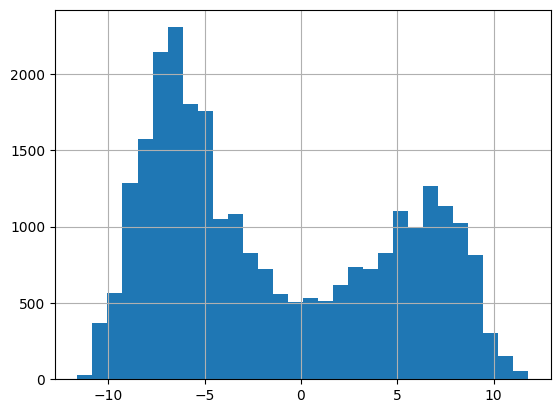

In [24]:
# 3rd diagnostic 
df_signal['vote_total'].hist(bins=30)
df_signal['vote_total'].autocorr(lag=1)

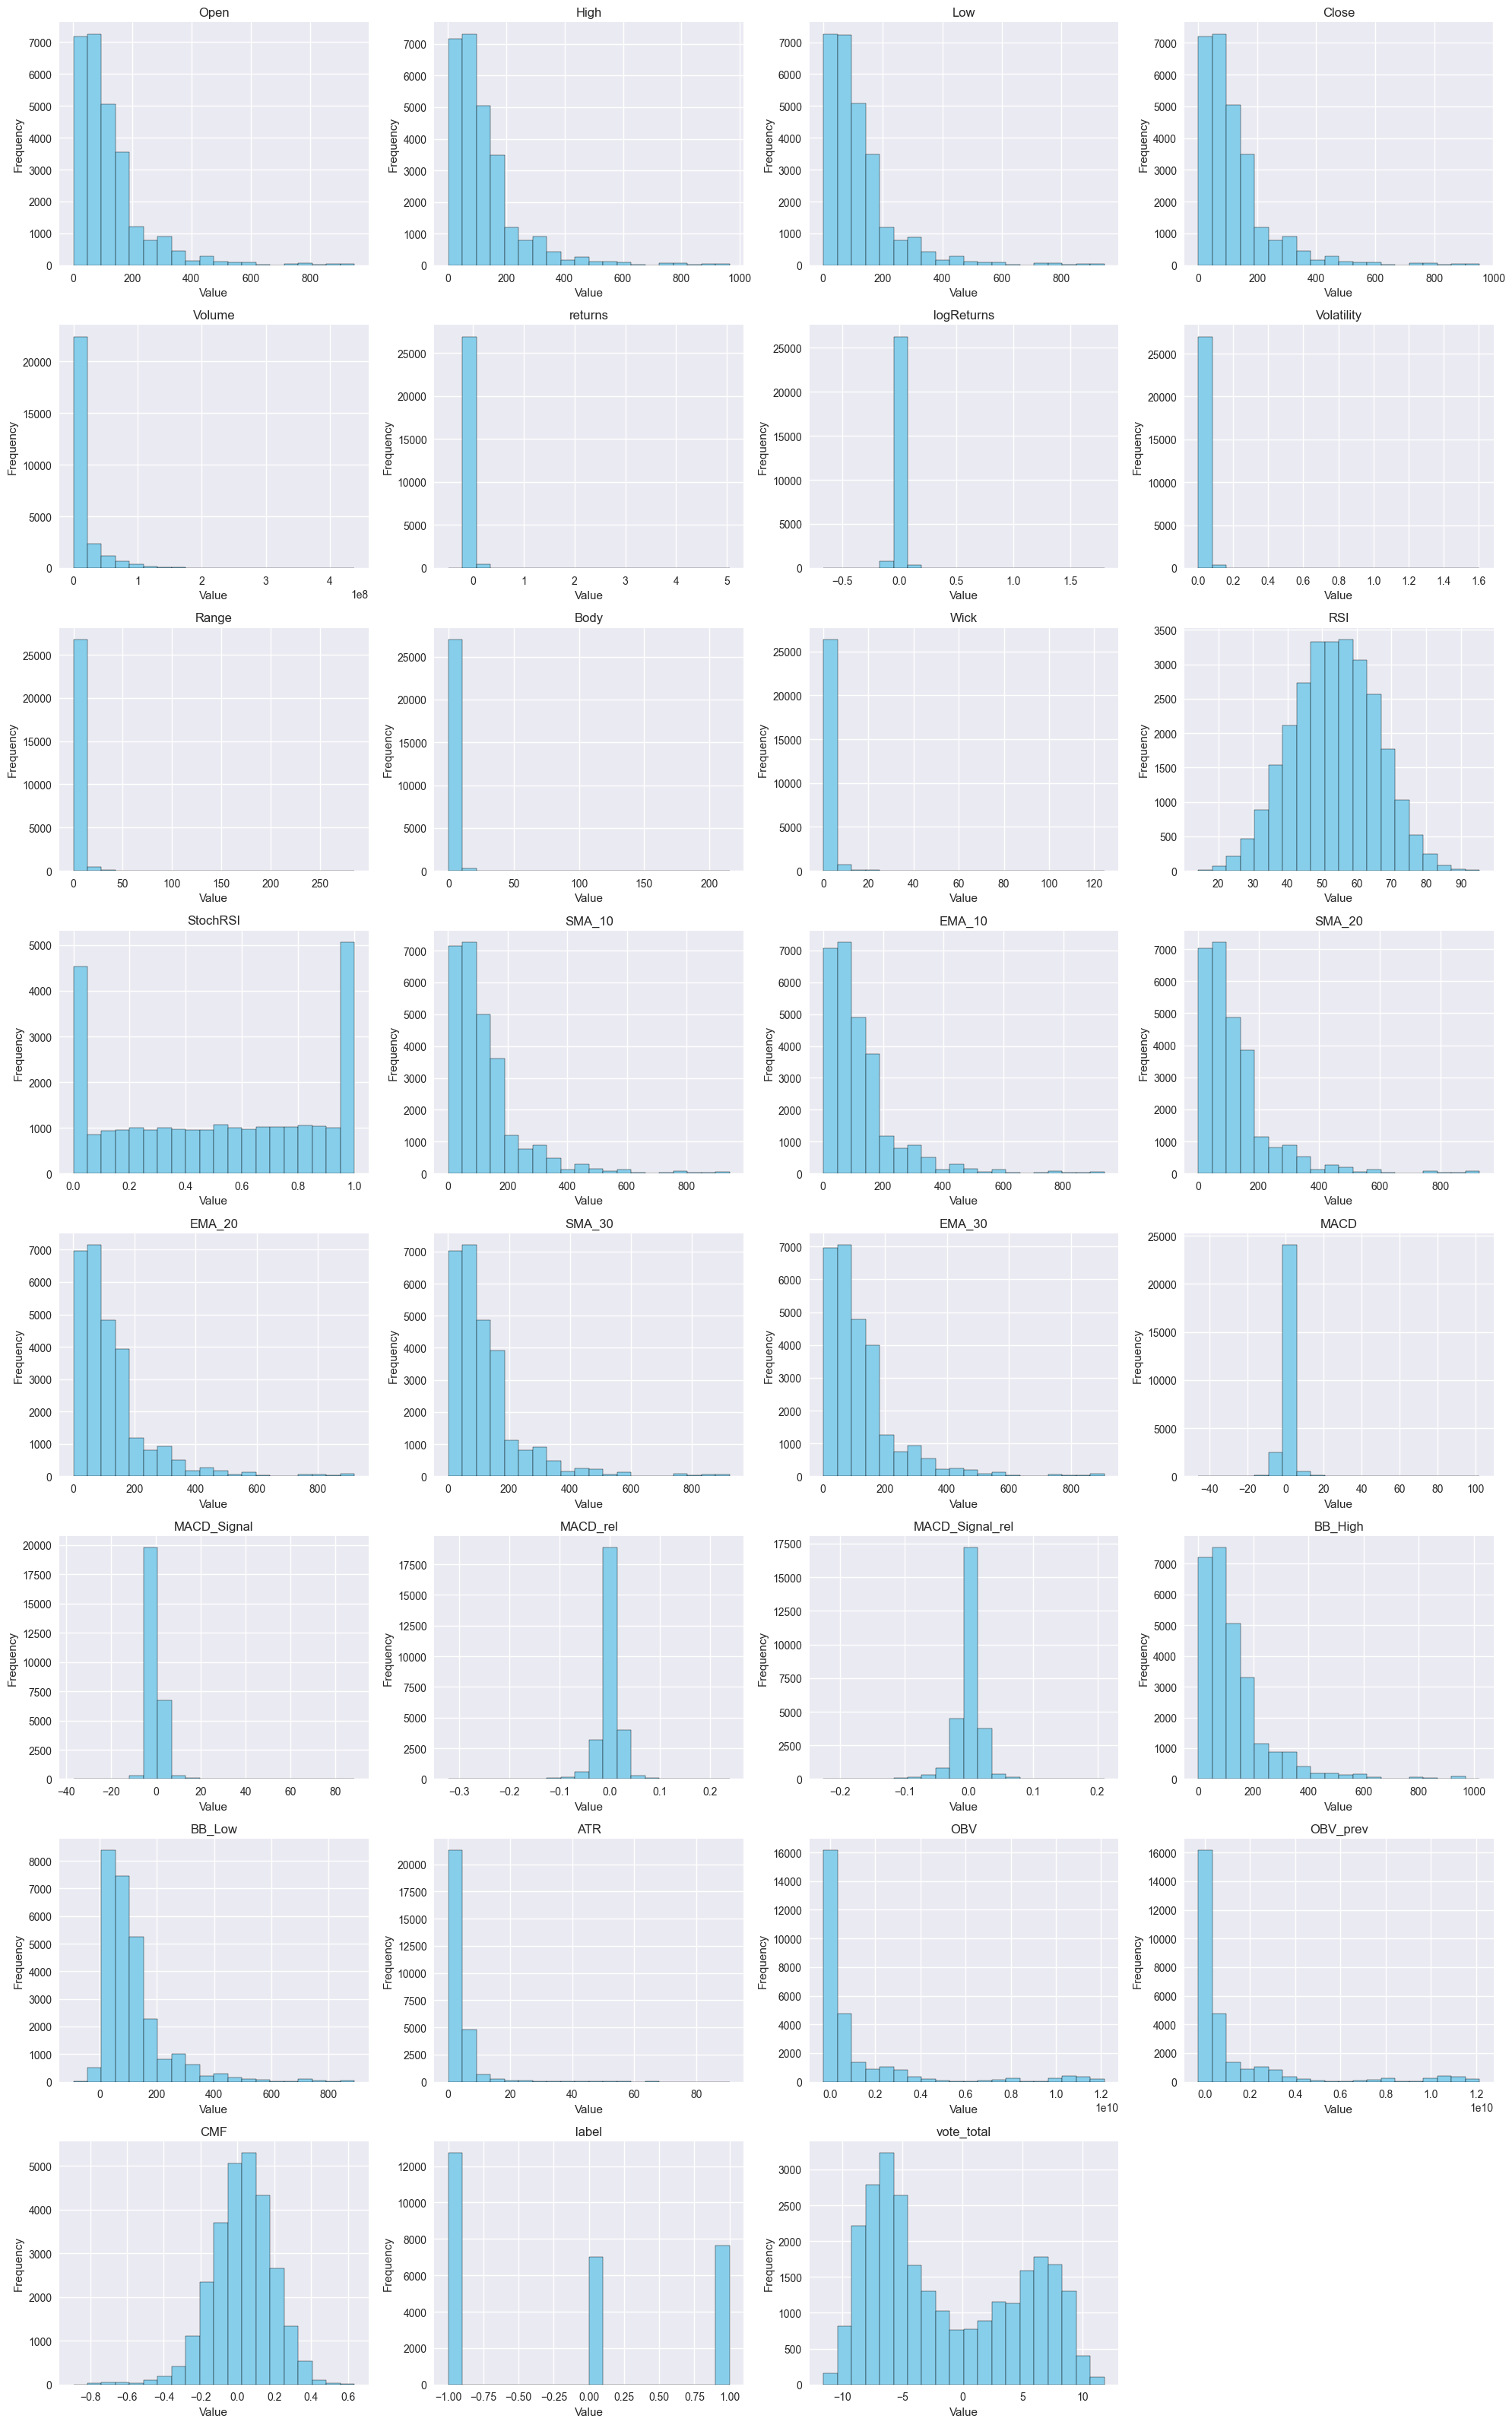

In [25]:
# Filter only existing columns
existing_cols = [col for col in df_signal.columns]
# Plot settings
plt.style.use('seaborn-v0_8')
n_cols = 4
n_rows = -(-len(existing_cols) // n_cols)  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(existing_cols):
    axes[i].hist(df_signal[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


#### Operation pipeline

LSTM functions

In [41]:
def make_lstm_dataset(df_features, target_col, sequence_length=60):
    """
    Convert features + target into LSTM-ready sequences.
    
    Parameters
    ----------
    df_features : pd.DataFrame
        Normalized features including target column.
    target_col : str
        Name of the regression target column.
    sequence_length : int
        Number of timesteps per sequence.
    
    Returns
    -------
    X : np.ndarray
        Shape (n_samples, sequence_length, n_features)
    y : np.ndarray
        Shape (n_samples,)
    """
    data = df_features.values
    target = df_features[target_col].values
    
    X, y = [], []
    for i in range(len(df_features) - sequence_length):
        # slice features for this window
        X.append(data[i:i+sequence_length, :])
        # target is aligned with the last timestep in the window
        y.append(target[i+sequence_length])
    
    X = np.array(X)
    y = np.array(y)
    return X, y


In [27]:
def walk_forward_split(X, y, n_splits=5):
    """
    Create walk-forward train/test splits using scikit-learn's TimeSeriesSplit.

    Parameters
    ----------
    X : np.ndarray
        Feature array of shape (n_samples, timesteps, n_features).
    y : np.ndarray
        Target array of shape (n_samples,).
    n_splits : int
        Number of sequential folds.

    Returns
    -------
    splits : list of tuples
        Each tuple is (X_train, y_train, X_test, y_test).
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        splits.append((X_train, y_train, X_test, y_test))

    return splits



In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, units1=64, units2=32, dense_units=32, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        # First LSTM layer (returns sequences)
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=units1, batch_first=True)
        
        # Second LSTM layer (returns final hidden state)
        self.lstm2 = nn.LSTM(input_size=units1, hidden_size=units2, batch_first=True)
        
        # Dense + Dropout + Output
        self.fc1 = nn.Linear(units2, dense_units)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(dense_units, 1)  # regression output

    def forward(self, x):
        # x shape: (batch, seq_len, features)
        out, _ = self.lstm1(x)
        out, (h_n, _) = self.lstm2(out)
        
        # Take last hidden state from second LSTM
        out = h_n[-1]  # shape: (batch, units2)
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc_out(out)
        return out


In [33]:
def train_lstm(X_train, y_train, device, epochs=50, batch_size=32, patience=5):
    """
    Train LSTM on given train set using PyTorch.
    """
    n_features = X_train.shape[2]
    model = LSTMModel(input_size=n_features).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert numpy arrays to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    best_loss = float("inf")
    patience_counter = 0
    history = {"train_loss": []}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)

        epoch_loss /= len(loader.dataset)
        history["train_loss"].append(epoch_loss)

        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_state)
    return model, history



In [71]:
def evaluate_strategy(
    preds,
    y_true,
    horizon=30,
    initial_capital=10_000,
    clip=0.02,
    rolling=True,
    rolling_window=60
):
    """
    Evaluate a trading strategy over a fixed prediction horizon.

    If rolling=True, divides data into non-overlapping horizon-day chunks and compounds
    capital across them — useful for periodic retraining or re-entry simulation.

    Args:
        preds : np.ndarray
            Model predictions (signals or expected returns).
        y_true : np.ndarray
            True daily returns (e.g. 0.001 = 0.1%).
        horizon : int
            Prediction horizon (e.g. 15 or 30 days).
        initial_capital : float
            Starting portfolio value.
        clip : float
            Max absolute daily return to avoid overflow.
        rolling : bool
            If True, simulate repeated trades across horizon segments.
            If False, only evaluate first horizon window.
        rolling_window : int
            Window for rolling Sharpe computation.
    """

    capital = initial_capital
    cumulative_curve = [capital]
    all_strategy_returns = []

    n = len(y_true)
    step_range = range(0, n - horizon + 1, horizon) if rolling else [0]

    for start in step_range:
        end = start + horizon
        p = preds[start:end]
        r = y_true[start:end]
        if len(r) < 1:
            continue

        positions = np.sign(p)
        strategy_returns = positions * r
        strategy_returns = np.clip(strategy_returns, -clip, clip)

        log_returns = np.log1p(strategy_returns)
        local_curve = capital * np.exp(np.cumsum(log_returns))

        capital = local_curve[-1]
        cumulative_curve.extend(local_curve[1:].tolist())
        all_strategy_returns.extend(strategy_returns.tolist())

    cumulative_curve = np.array(cumulative_curve)
    all_strategy_returns = np.array(all_strategy_returns)

    # === Core metrics ===
    mean_daily_return = np.mean(all_strategy_returns)
    volatility = np.std(all_strategy_returns)
    sharpe_ratio = mean_daily_return / volatility if volatility > 0 else np.nan
    total_return = cumulative_curve[-1] / initial_capital - 1

    # === Drawdown computation ===
    cummax_curve = np.maximum.accumulate(cumulative_curve)
    drawdown = (cumulative_curve / cummax_curve) - 1

    # === Rolling Sharpe (optional) ===
    rolling_sharpe = None
    if len(all_strategy_returns) >= rolling_window:
        r_series = pd.Series(all_strategy_returns)
        rolling_mean = r_series.rolling(rolling_window).mean()
        rolling_std = r_series.rolling(rolling_window).std()
        rolling_sharpe = (rolling_mean / rolling_std).fillna(0)

    return {
        "total_return": total_return,
        "mean_daily_return": mean_daily_return,
        "volatility": volatility,
        "sharpe_ratio": sharpe_ratio,
        "cumulative_curve": cumulative_curve,
        "drawdown": drawdown,
        "rolling_sharpe": rolling_sharpe,
        "strategy_returns": all_strategy_returns,
    }


In [77]:
def plot_strategy_curve(metrics, title="Equity Curve (Absolute)"):
    curve = metrics["cumulative_curve"]
    drawdown = metrics.get("drawdown", None)
    rolling_sharpe = metrics.get("rolling_sharpe", None)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(curve, label="Equity Curve ($)", color="blue", linewidth=2)
    ax1.set_xlabel("Days")
    ax1.set_ylabel("Portfolio Value ($)")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Plot drawdown on secondary y-axis (if available)
    if drawdown is not None:
        ax2 = ax1.twinx()
        ax2.fill_between(range(len(drawdown)), drawdown, color="red", alpha=0.2, label="Drawdown")
        ax2.set_ylabel("Drawdown (%)")

    plt.title(title)
    fig.legend(loc="upper left")
    plt.show()


#### Training Pipeline + Quick Validation


=== Training horizon 15 days ===

===== Fold 0 =====
Train shape: (4522, 60, 33), Test shape: (4522, 60, 33)
Early stopping triggered.
Fold 0 Prediction Metrics:
  RMSE = 0.0033
  MAE  = 0.0028
  DirAcc = 62.78%
Fold 0 Strategy Metrics:
  NetReturn = -99.31%
  Sharpe    = -0.20
  MeanDaily = -0.0011
  Volatility = 0.0055


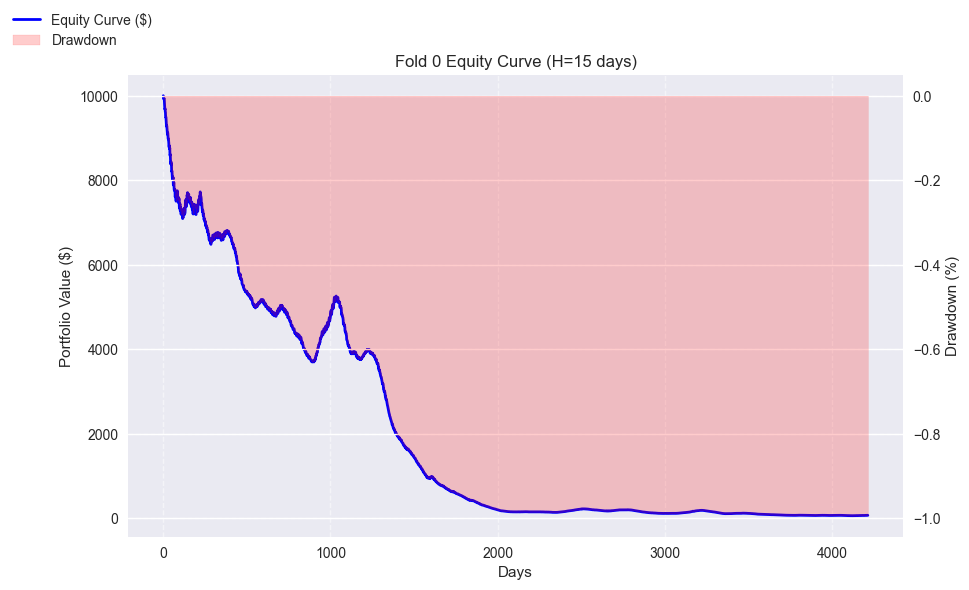


===== Fold 1 =====
Train shape: (9044, 60, 33), Test shape: (4522, 60, 33)
Early stopping triggered.
Fold 1 Prediction Metrics:
  RMSE = 0.0024
  MAE  = 0.0018
  DirAcc = 51.88%
Fold 1 Strategy Metrics:
  NetReturn = 4363.84%
  Sharpe    = 0.16
  MeanDaily = 0.0009
  Volatility = 0.0055


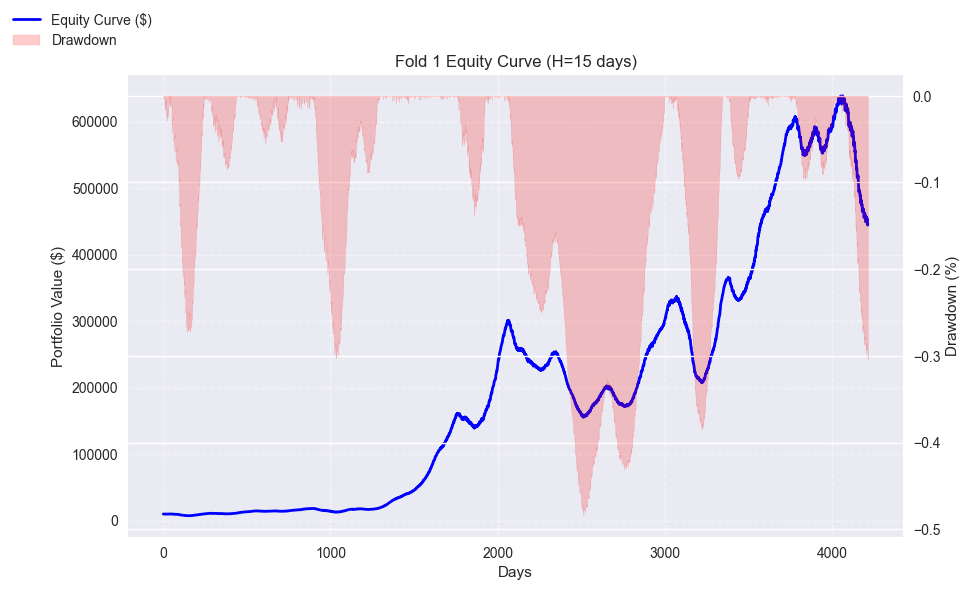


===== Fold 2 =====
Train shape: (13566, 60, 33), Test shape: (4522, 60, 33)
Early stopping triggered.
Fold 2 Prediction Metrics:
  RMSE = 0.0029
  MAE  = 0.0021
  DirAcc = 46.84%
Fold 2 Strategy Metrics:
  NetReturn = 11528.41%
  Sharpe    = 0.20
  MeanDaily = 0.0011
  Volatility = 0.0055


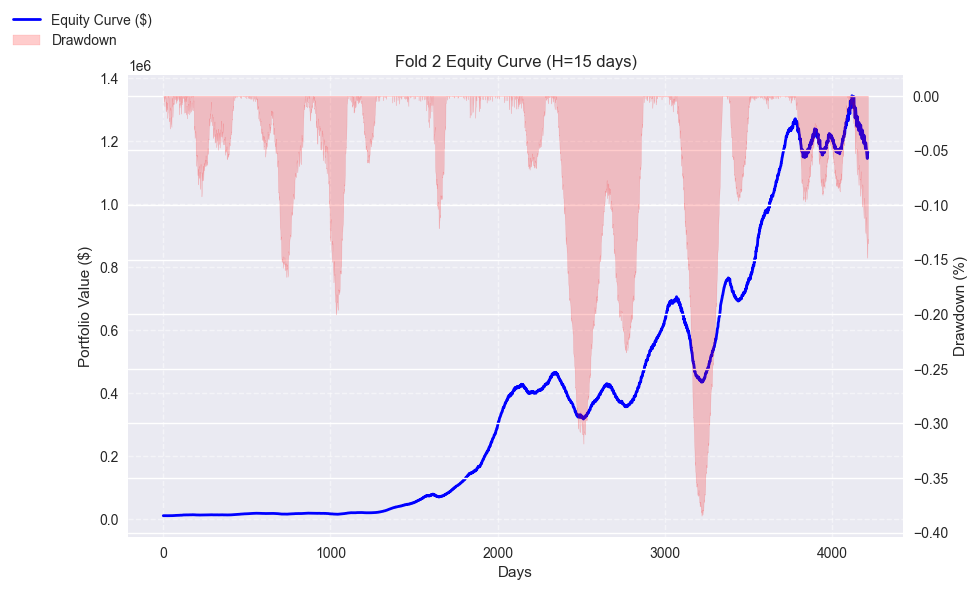


===== Fold 3 =====
Train shape: (18088, 60, 33), Test shape: (4522, 60, 33)
Early stopping triggered.
Fold 3 Prediction Metrics:
  RMSE = 0.0028
  MAE  = 0.0020
  DirAcc = 64.04%
Fold 3 Strategy Metrics:
  NetReturn = -98.37%
  Sharpe    = -0.16
  MeanDaily = -0.0009
  Volatility = 0.0055


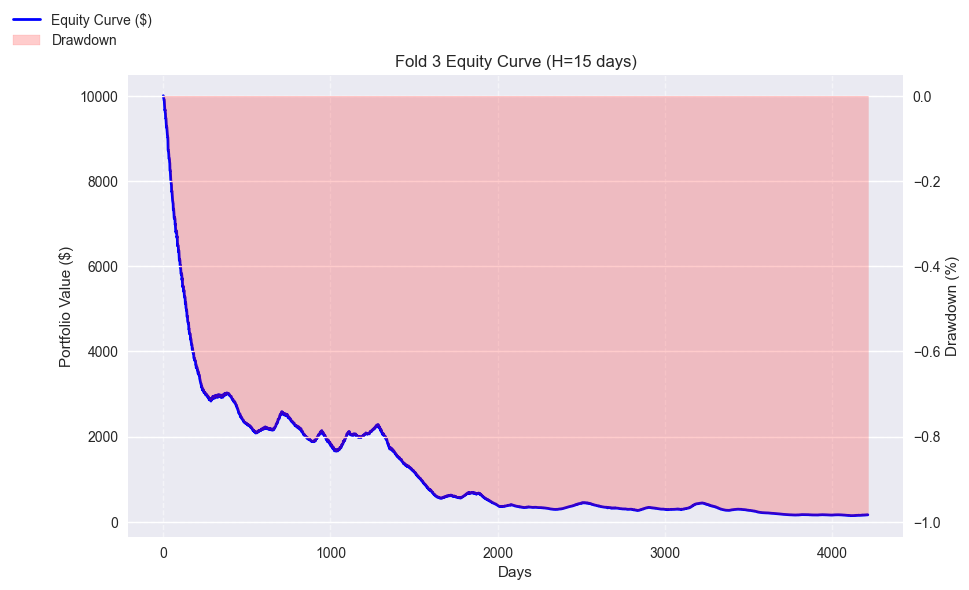


===== Fold 4 =====
Train shape: (22610, 60, 33), Test shape: (4522, 60, 33)
Early stopping triggered.
Fold 4 Prediction Metrics:
  RMSE = 0.0038
  MAE  = 0.0028
  DirAcc = 42.30%
Fold 4 Strategy Metrics:
  NetReturn = 59049.28%
  Sharpe    = 0.27
  MeanDaily = 0.0014
  Volatility = 0.0054


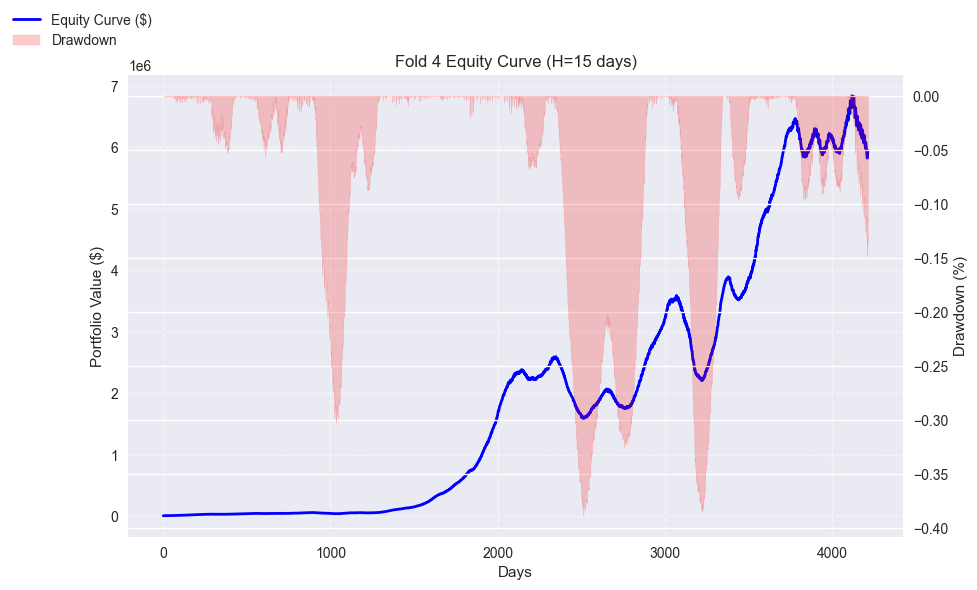


=== Training horizon 30 days ===

===== Fold 0 =====
Train shape: (4497, 60, 33), Test shape: (4494, 60, 33)
Fold 0 Prediction Metrics:
  RMSE = 0.0015
  MAE  = 0.0011
  DirAcc = 72.25%
Fold 0 Strategy Metrics:
  NetReturn = -96.25%
  Sharpe    = -0.17
  MeanDaily = -0.0007
  Volatility = 0.0044


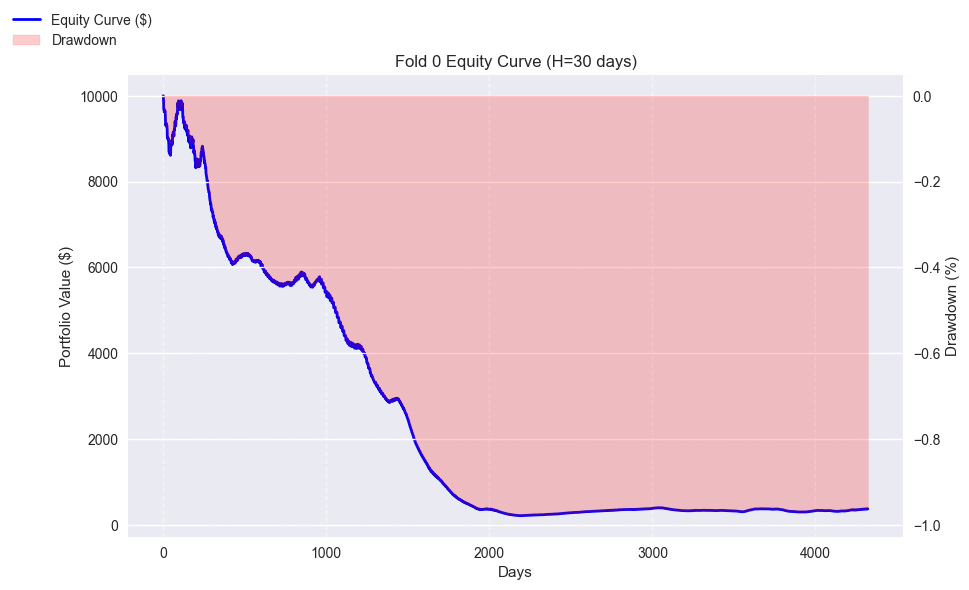


===== Fold 1 =====
Train shape: (8991, 60, 33), Test shape: (4494, 60, 33)
Early stopping triggered.
Fold 1 Prediction Metrics:
  RMSE = 0.0016
  MAE  = 0.0012
  DirAcc = 72.76%
Fold 1 Strategy Metrics:
  NetReturn = -97.81%
  Sharpe    = -0.19
  MeanDaily = -0.0008
  Volatility = 0.0043


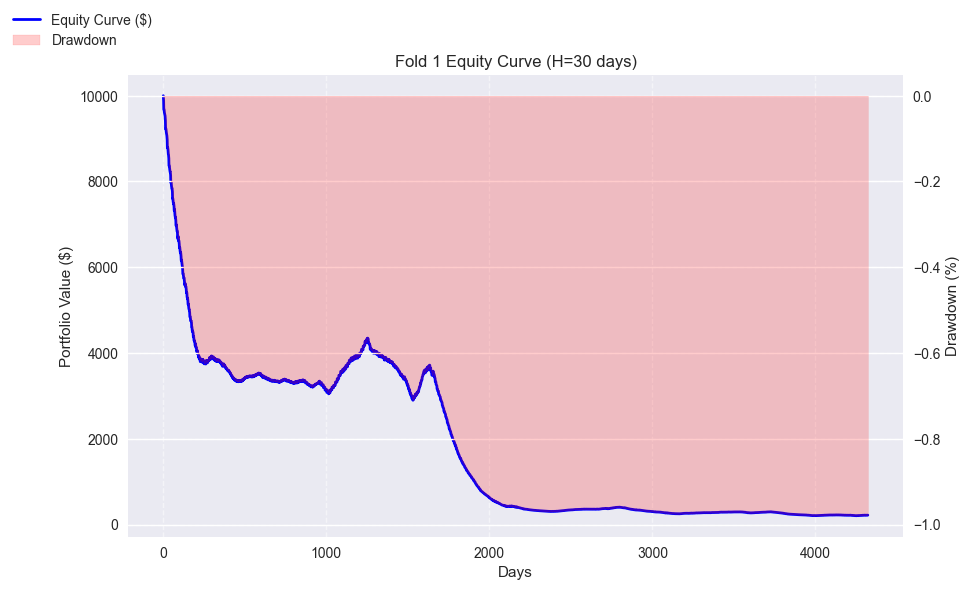


===== Fold 2 =====
Train shape: (13485, 60, 33), Test shape: (4494, 60, 33)
Early stopping triggered.
Fold 2 Prediction Metrics:
  RMSE = 0.0019
  MAE  = 0.0013
  DirAcc = 60.39%
Fold 2 Strategy Metrics:
  NetReturn = 9052.41%
  Sharpe    = 0.24
  MeanDaily = 0.0010
  Volatility = 0.0043


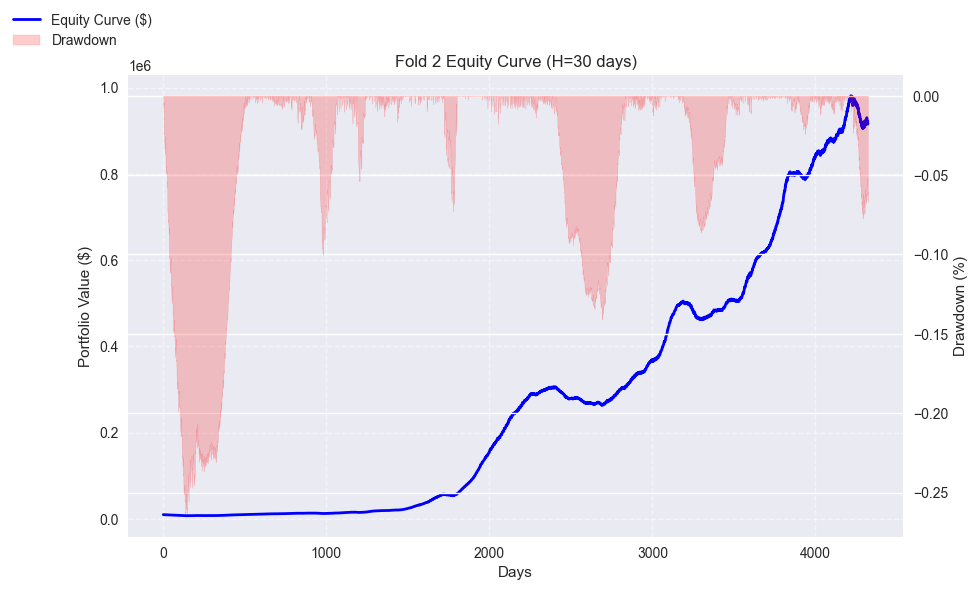


===== Fold 3 =====
Train shape: (17979, 60, 33), Test shape: (4494, 60, 33)
Early stopping triggered.
Fold 3 Prediction Metrics:
  RMSE = 0.0021
  MAE  = 0.0016
  DirAcc = 70.07%
Fold 3 Strategy Metrics:
  NetReturn = -94.38%
  Sharpe    = -0.14
  MeanDaily = -0.0006
  Volatility = 0.0044


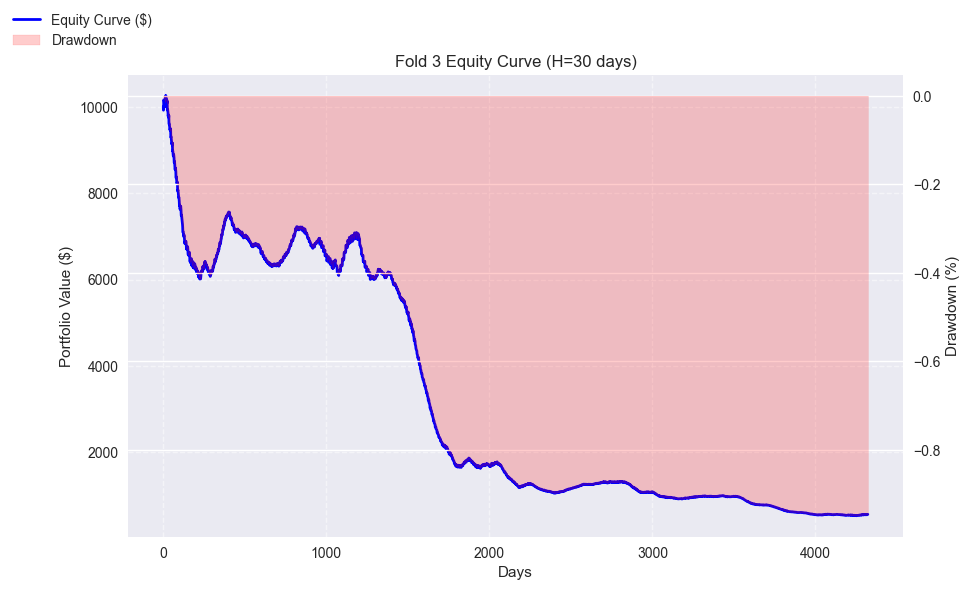


===== Fold 4 =====
Train shape: (22473, 60, 33), Test shape: (4494, 60, 33)
Early stopping triggered.
Fold 4 Prediction Metrics:
  RMSE = 0.0026
  MAE  = 0.0020
  DirAcc = 45.26%
Fold 4 Strategy Metrics:
  NetReturn = 151859.87%
  Sharpe    = 0.40
  MeanDaily = 0.0016
  Volatility = 0.0041


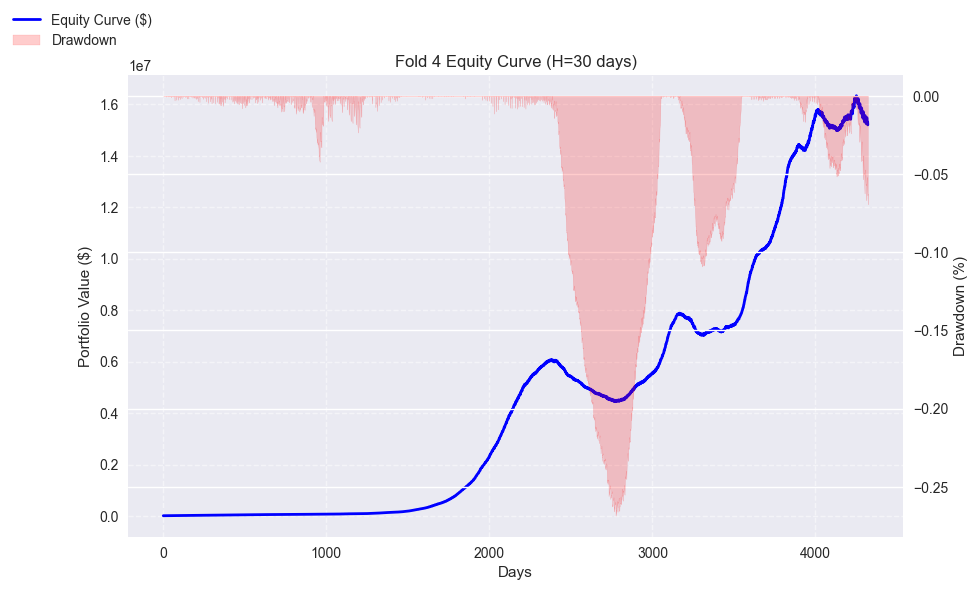

In [78]:
# df_processed: dataframe containing the technical indicators
BLEND_WEIGHT = 0.7
EPOCHS = 20
SEQUENCE_LENGTH = 60  # lookback window
horizons = [15, 30]

for h in horizons:
    print(f"\n=== Training horizon {h} days ===")

    # 1. Prepare data
    df_h = df_processed.copy()
    df_h = signal_engine_v2(df_h)
    df_h = add_future_return(df_h, h)
    df_h = generate_regression_target(df_h, h, BLEND_WEIGHT)
    df_h = df_h.dropna()

    # 2. Normalize features
    df_features, scaler = normalize_features(df_h, h)

    # 3. Build sequences
    target_col = f"target_reg_{h}"
    X, y = make_lstm_dataset(df_features, target_col=target_col, sequence_length=SEQUENCE_LENGTH)

    # 4. Walk-forward splits
    splits = walk_forward_split(X, y, n_splits=5)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 5. Train and evaluate per fold
    for i, (X_train, y_train, X_test, y_test) in enumerate(splits):
        print(f"\n===== Fold {i} =====")
        print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

        # --- Build and train model ---
        model, history = train_lstm(X_train, y_train, device=device, epochs=EPOCHS)
        model.eval()

        # --- Prepare test tensors ---
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

        # --- Predict on test set ---
        with torch.no_grad():
            preds_tensor = model(X_test_tensor).squeeze()
        preds = preds_tensor.cpu().numpy()

        # --- Prediction metrics (vs blended target) ---
        rmse = np.sqrt(np.mean((preds - y_test) ** 2))
        mae = np.mean(np.abs(preds - y_test))
        dir_acc = np.mean((preds >= 0) == (y_test >= 0))

        print(f"Fold {i} Prediction Metrics:")
        print(f"  RMSE = {rmse:.4f}")
        print(f"  MAE  = {mae:.4f}")
        print(f"  DirAcc = {dir_acc:.2%}")

        # --- Strategy metrics (vs actual forward returns) ---
        future_col = f"f_return_{h}"  # h = horizon (e.g., 15 or 30)
        actual_returns = (1 + df_h[future_col].iloc[-len(y_test):].values) ** (1 / h) - 1

        # Baseline: buy-and-hold over the same period
        baseline_curve = np.cumprod(1 + actual_returns)
        baseline_total_return = baseline_curve[-1] - 1

        # Evaluate strategy with horizon-aware function
        metrics = evaluate_strategy(
            preds=preds,
            y_true=actual_returns,
            horizon=h,
            initial_capital=10_000,
            clip=0.02,
            rolling=True  # False for short simulation
        )

        print(f"Fold {i} Strategy Metrics:")
        print(f"  NetReturn = {metrics['total_return']:.2%}")
        print(f"  Sharpe    = {metrics['sharpe_ratio']:.2f}")
        print(f"  MeanDaily = {metrics['mean_daily_return']:.4f}")
        print(f"  Volatility = {metrics['volatility']:.4f}")

        # --- Plot equity curve ---
        plot_strategy_curve(metrics, title=f"Fold {i} Equity Curve (H={h} days)")


In [76]:
metrics["cumulative_curve"][:10]

array([10000.        , 10077.8042756 , 10118.74453547, 10320.23725327,
       10313.58915635, 10313.82539967, 10367.54337829, 10393.44358492,
       10413.053384  , 10426.43181464])